# Introduction/Business Problem

Our goal here is to identify similar neighborhoods across 2 different cities New York and Toronto, based on the most popular venue categories of the neighborhood. 

We will utilize the Foursquare Location API, to find out the popular venue categories for each of the neighborhoods of New York and Toronto.

This is useful for people, who are likely to move on from New York to Toronto or Toronto to New York, and are looking to move to a neighbourhood with the similar characteristics (the same popular venue categories) as the one they are currently living in.

# Data

Foursquare is a location data provider. We need to create a foursquare developer account and get the credentials to extract the data. The Foursqure website link to create the account is: https://developer.foursquare.com/ . The data can be extracted using the API or the foursquare python package.  

Using foursquare data, we can search for nearby venues of a specific type, explore a particular venue, and search for trending venues around a location and many more. To find the most popular venue categories, we will be using the explore endpoint of the Foursquare API.  


We make use of the data provided by the New York Univeristy, to get the list of neighborhoods in the New York City along with their lat long values. The link is : https://geo.nyu.edu/catalog/nyu_2451_34572

We web scrape the list of Toronto neighborhoods from wikipedia and map the respective lat lng values, using the file Geospatial_coordinates.csv. The wikipedia page is: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

## Imports & Settings

In [60]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans # import k-means algorithm for clustering
from sklearn.metrics import silhouette_samples

import folium # map rendering library

import foursquare # to retrive the foursquare location data

import requests # library to handle http requests
from bs4 import BeautifulSoup

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

import time
from tqdm import tqdm

from sklearn.cluster import DBSCAN

print('Libraries imported.')

Libraries imported.


## Utility Methods 

In [173]:
def get_city(row):
    nbh_lst = row['Splitted']
    return nbh_lst[-1] 

def get_category_type(row):
    '''function that extracts the category of the venue'''
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def getPopularVenues(names, latitudes, longitudes, file_name='all_neighborhoods.csv', radius=1000, LIMIT=100):
    '''Method to retrieve the popular venues for all the neighborhoods'''
    all_neighborhoods = pd.DataFrame()
    
    for name, lat, lng in tqdm(zip(names, latitudes, longitudes)):
        ll_str = str(lat) + ',' + str(lng)
        response = client.venues.explore(params={"ll": ll_str, "radius": radius, "limit": LIMIT, 
                                                 "sortByPopularity": 1})
        popular_venues = json_normalize(response['groups'][0]['items']) 
        
        # filter columns
        filtered_columns = ['venue.name', 'venue.location.lat', 'venue.location.lng', 'venue.categories']
        popular_venues = popular_venues.loc[:, filtered_columns].copy()
        
        # filter the category for each row
        popular_venues['venue.categories'] = popular_venues.apply(get_category_type, axis=1)
        
        # change the columns names
        popular_venues.columns = ['Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
        popular_venues['Popularity Order'] = np.arange(popular_venues.shape[0], 0, -1)
        # add the neighborhood name, lat & lng
        popular_venues.insert(0,'Neighborhood', name)
        popular_venues.insert(1,'Neighborhood Latitude', lat)
        popular_venues.insert(2,'Neighborhood Longitude', lng)
        
        all_neighborhoods = pd.concat([all_neighborhoods, popular_venues])
        all_neighbourhoods.reset_index(drop=True, inplace=True)
        all_neighborhoods.to_csv(file_name, index=False)
    
    return all_neighborhoods

def return_most_popular_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

def get_top10_popular_venues(popular_categories_wide, record_type='Neighborhood'):
    num_top_venues = 10
    
    indicators = ['st', 'nd', 'rd']
    
    # create columns according to number of top venues
    columns = [record_type]
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Popular Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Popular Venue'.format(ind+1))
    
    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted[record_type] = popular_categories_wide[record_type]
    
    for ind in np.arange(popular_categories_wide.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = \
        return_most_popular_venues(popular_categories_wide.iloc[ind, :], num_top_venues)
    
    return neighborhoods_venues_sorted  

## Load the New York Data

In [49]:
with open('nyu-2451-34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
ny_neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_neighborhoods = ny_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
ny_neighborhoods['City'] = 'New York'
print(ny_neighborhoods.shape)
ny_neighborhoods.head(2)

(306, 5)


,Borough,Neighborhood,Latitude,Longitude,City
0,Bronx,Wakefield,40.894705,-73.847201,New York
1,Bronx,Co-op City,40.874294,-73.829939,New York


## Load the Toronto Data 

In [50]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
to_neighborhoods = pd.read_html(str(table))[0]
to_neighborhoods = to_neighborhoods[to_neighborhoods.Borough!='Not assigned'].copy()
to_cord_df = pd.read_csv('Geospatial_Coordinates.csv')
to_neighborhoods = to_neighborhoods.merge(to_cord_df)
# to_neighborhoods = to_neighborhoods.iloc[:,1:].copy()
to_neighborhoods['City'] = 'Toronto'
print(to_neighborhoods.shape)
to_neighborhoods.head(2)

(103, 6)


,Postal Code,Borough,Neighborhood,Latitude,Longitude,City
0,M3A,North York,Parkwoods,43.753259,-79.329656,Toronto
1,M4A,North York,Victoria Village,43.725882,-79.315572,Toronto


## Concat both the data

In [52]:
neighborhoods = pd.concat([ny_neighborhoods, to_neighborhoods], sort=True)
neighborhoods.rename(columns={'Neighborhood': 'Neighborhood Name'}, inplace=True)
concat_cols = ['Postal Code', 'Neighborhood Name', 'Borough', 'City']
# concat 4 columns into one with separator as ', ' ignoring nan postal codes
neighborhoods.insert(0,'Neighborhood', neighborhoods[concat_cols].apply(lambda x: x.str.cat(sep=', '), axis=1))
neighborhoods.drop(columns=['Borough', 'Neighborhood Name', 'City', 'Postal Code'], inplace=True)
# data not available in foursquare for this neighborhood
neighborhoods = neighborhoods[neighborhoods.Neighborhood != 'M1X, Upper Rouge, Scarborough, Toronto'].copy()
neighborhoods.reset_index(drop=True, inplace=True)

print(neighborhoods.shape)
neighborhoods.head(2)

(408, 3)


,Neighborhood,Latitude,Longitude
0,"Wakefield, Bronx, New York",40.894705,-73.847201
1,"Co-op City, Bronx, New York",40.874294,-73.829939


## Foursquare Location Data

Next, lets retrieve the top 100 popular venues for each of the neighborhood

In [5]:
# Construct the client object
client = foursquare.Foursquare(client_id='ZQAHVAGKCEDOODA0MPBCI0524UZTNF4LCEUTBHC3OZVBTKNX ', 
                               client_secret='LZBGKXOGTV3SOCFKYWQGNOZ5ICRBFQ1WFAKQC2RQPF4ROE0G', 
                               redirect_uri='http://fondu.com/oauth/authorize')

# Build the authorization url for your app
auth_uri = client.oauth.auth_url()
auth_uri

'https://foursquare.com/oauth2/authenticate?client_id=ZQAHVAGKCEDOODA0MPBCI0524UZTNF4LCEUTBHC3OZVBTKNX+&response_type=code&redirect_uri=http%3A%2F%2Ffondu.com%2Foauth%2Fauthorize'

### Get Popular Venues

In [101]:
start_time = time.time()
all_neighbourhoods = getPopularVenues(names=neighborhoods['Neighborhood'], 
                                      latitudes=neighborhoods['Latitude'], 
                                      longitudes=neighborhoods['Longitude'])
run_time = round((time.time() - start_time) / 60)
print('Venues details fetched from Foursquare Location API in {} minutes'.format(run_time))
print(all_neighbourhoods.shape)
all_neighbourhoods.head(2)

408it [15:55,  2.34s/it]


Venues details fetched from Foursquare Location API in 16 minutes
(25494, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Popularity Order
0,"Wakefield, Bronx, New York",40.894705,-73.847201,Dunkin',40.898390,-73.854643,Donut Shop,44
1,"Wakefield, Bronx, New York",40.894705,-73.847201,Rite Aid,40.892284,-73.858303,Pharmacy,43


In [3]:
all_neighbourhoods = pd.read_csv('all_neighborhoods.csv')
print(all_neighbourhoods.shape)
print("No of Neighborhoods: {}".format(len(all_neighbourhoods.Neighborhood.unique())))
all_neighbourhoods.head(2)

(25494, 8)
No of Neighborhoods: 408


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Popularity Order
0,"Wakefield, Bronx, New York",40.894705,-73.847201,Dunkin',40.898390,-73.854643,Donut Shop,44
1,"Wakefield, Bronx, New York",40.894705,-73.847201,Rite Aid,40.892284,-73.858303,Pharmacy,43


In [4]:
# Pick the max Popularity Index for each Venue Category
filter_columns = ['Neighborhood','Venue Category','Popularity Order']
popularity_df = all_neighbourhoods[filter_columns].groupby(['Neighborhood','Venue Category']).max()
popularity_df.reset_index(inplace=True)
popularity_df.sort_values(['Neighborhood','Popularity Order'],ascending=[True,False], inplace=True)
popularity_df.reset_index(drop=True, inplace=True)
print(popularity_df.shape)
popularity_df.head(2)

(15479, 3)


,Neighborhood,Venue Category,Popularity Order
0,"Allerton, Bronx, New York",Supermarket,66
1,"Allerton, Bronx, New York",Fast Food Restaurant,65


# Methodology

Both the New York and Toronto Neighborhood's lat long data are concatened and passed to the Foursquare explore method, with sortByPopularity set to 1, radius set to 1000 m and limit set to 100, so that the venues are within 1 km and not more than 100 venues are fetched for each neighborhood and the venues are sorted by the popularity. 

Using this output I got sorted by Popularity, I'm going to assign each venue a popularity order. For example, let's say for a Neighborhood N1, the Foursquare API provides 5 venues as below:

| Neighborhood | Venue | Venue Category |
|--------------|-------|----------------|
|   N1         | V1    | VC1            |
|   N1         | V2    | VC1            |
|   N1         | V3    | VC2            |
|   N1         | V4    | VC2            |
|   N1         | V5    | VC3            |

The Popularity Order will be assigned in descending Order as below:

| Neighborhood | Venue | Venue Category | Popularity Order |
|--------------|-------|----------------|------------------|
|   N1         | V1    | VC1            | 5                |
|   N1         | V2    | VC1            | 4                |
|   N1         | V3    | VC2            | 3                |
|   N1         | V4    | VC2            | 2                |
|   N1         | V5    | VC3            | 1                |

Then we pick the max popularity order for each venue category, so that we could get the Popularity Order at the Venue Category Level. It will look something like below:

| Neighborhood | Venue Category | Popularity Order |
|--------------|----------------|------------------|
|   N1         | VC1            | 5                |
|   N1         | VC2            | 3                |
|   N1         | VC3            | 1                |

Now let's rank it using percentile method, so that the values range between 0 to 1. And we will name it as Popularity Index.

| Neighborhood | Venue Category | Popularity Index |
|--------------|----------------|------------------|
|   N1         | VC1            | 1                |
|   N1         | VC2            | 0.67             |
|   N1         | VC3            | 0.33             |

Now before feeding into the model, we will transform the data into wide format as below:

| Neighborhood | VC1 | VC2  | VC3  |
|--------------|-----|------|------|
|   N1         | 1   | 0.67 | 0.33 |

Also computed the top 10 popular venues as below

| Neighborhood | 1st Popular Venue | 2nd Popular Venue  | 3rd Popular Venue  |
|--------------|-------------------|--------------------|--------------------|
|   N1         | VC1               | VC2                | VC3                |


I did the following exploratory data analysis over the venue category, before running the model.  
1. To find the similar categories among a long list of venue categories, to group similar categories as one category. I found that most of the categories were different types of restaurants.
2. Do a bar plot on Venue Category, so that I could get an idea on how many neighborhoods have such a venue category.


I performed the following data cleaning work.    
1. Noticed that many categories are available in just less than 50 neighborhoods among the 408 neighborhoods. Hence decided to clean up those categories.
2. Grouped all the categories that have restaurant in its name and the neighborhood count is less than or equal to 50  as a common Restaurant Category
3. Removed all the rest of the categories that have neighborhood count less than 50

I selected the KMeans Algorithm to cluster the Neighborhoods. To find out the optimal number of clusters I'm using the Elbow method and doing the Silhouette Analysis. And I selected k=6 as the optimal number of clusters and ran the model using it.

## Exploratory Data Analysis

### Similar categories - Word Cloud

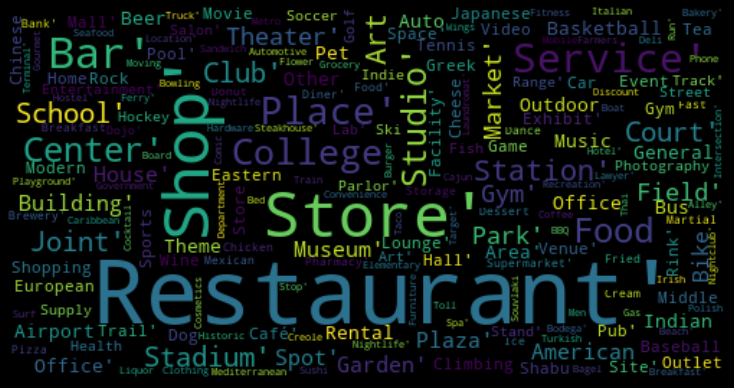

In [191]:
# common words in the category
text = popularity_df['Venue Category'].unique()
wordcloud = WordCloud(
    width = 500,
    height = 260,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [111]:
# get the count of unique categories for each neighborhood
unique_categories = popularity_df.groupby('Neighborhood')['Venue Category'].nunique().to_frame().reset_index()
unique_categories.rename(columns={'Venue Category': 'Count of Unique Venue Categories'}, inplace=True)
print(unique_categories.shape)
unique_categories.head(2)

(408, 2)


,Neighborhood,Count of Unique Venue Categories
0,"Allerton, Bronx, New York",36
1,"Annadale, Staten Island, New York",10


### Venue Category Bar Plot

Text(0.5, 0.98, 'Venue Category')

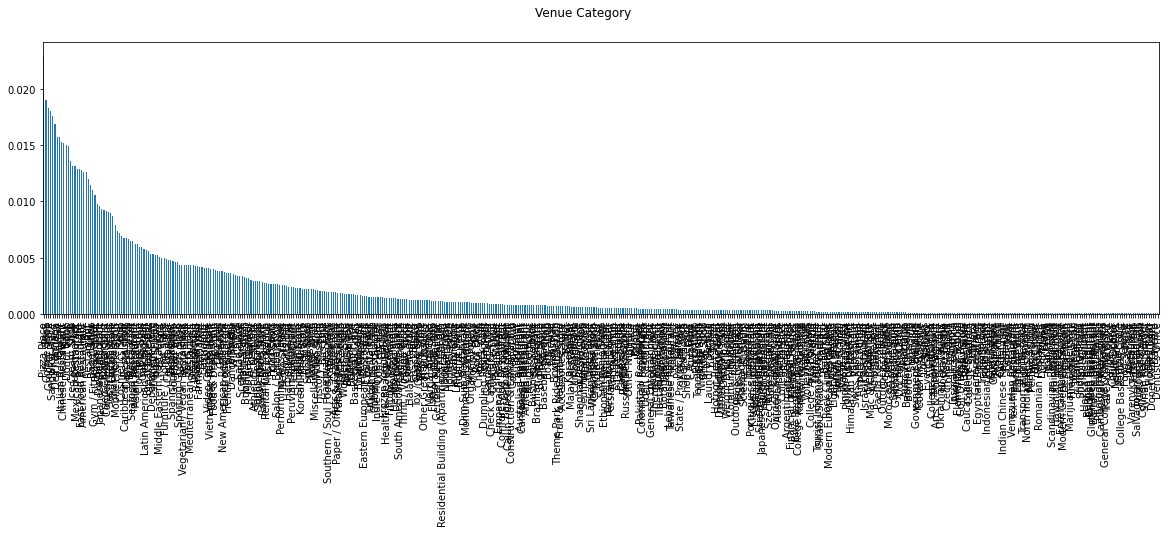

In [193]:
fig = plt.figure(figsize=(20,5))
popularity_df['Venue Category'].value_counts(normalize=True).plot(kind='bar')
fig.suptitle('Venue Category')

In [5]:
# Get the count of neighborhoods in which the category is available
cat_count = popularity_df.groupby(['Venue Category']).count()
cat_count = cat_count['Neighborhood'].reset_index()
cat_count.sort_values('Neighborhood', ascending=False, inplace=True)
cat_count.columns = ['Category', 'NbhCount']
cat_count.reset_index(inplace=True, drop=True)
print(cat_count.shape)
print("Min: {}, Max: {}".format(cat_count['NbhCount'].min(),cat_count['NbhCount'].max()))
cat_count.head()

(501, 2)
Min: 1, Max: 356


,Category,NbhCount
0,Pizza Place,356
1,Park,294
2,Coffee Shop,283
3,Grocery Store,279
4,Sandwich Place,272


## Data Cleaning

In [6]:
# Group all the categories that have restaurant in its name 
# and the neighborhood count is less than or equal to 50  as a common Restaurant Category
# Remove all the rest of the categories that have neighborhood count less than 50

restaurants = cat_count[(cat_count.NbhCount<=50)&(cat_count.Category.str.contains('Restaurant'))]
restaurants_lst = restaurants.Category.tolist()
other_categories = set(cat_count.loc[cat_count.NbhCount<50,'Category']) - set(restaurants_lst)

popular_nbhs = popularity_df.copy()
print("Count of unique categories before cleaning: ", len(popular_nbhs['Venue Category'].unique()))
popular_nbhs.loc[popular_nbhs['Venue Category'].isin(restaurants_lst + ['Food Service']), 'Venue Category'] = 'Restaurant'
popular_nbhs.loc[popular_nbhs['Venue Category'].isin(['Botanical Garden']), 'Venue Category'] = 'Park' 
popular_nbhs = popular_nbhs[~popular_nbhs['Venue Category'].isin(other_categories)].copy()
print("Count of unique categories after cleaning: ", len(popular_nbhs['Venue Category'].unique()))
popular_nbhs.reset_index(drop=True, inplace=True)

print(popular_nbhs.shape)
popular_nbhs.head(2)

Count of unique categories before cleaning:  501
Count of unique categories after cleaning:  92
(11825, 3)


,Neighborhood,Venue Category,Popularity Order
0,"Allerton, Bronx, New York",Supermarket,66
1,"Allerton, Bronx, New York",Fast Food Restaurant,65


In [7]:
# group them again after cleaning
final_popular_nbhs = popular_nbhs.groupby(['Neighborhood', 'Venue Category']).max()
final_popular_nbhs.reset_index(inplace=True)
final_popular_nbhs.sort_values(['Neighborhood', 'Popularity Order'], ascending=[True, False], 
                               inplace=True)
final_popular_nbhs.reset_index(drop=True, inplace=True)
print(final_popular_nbhs.shape)
final_popular_nbhs.head()

(11225, 3)


,Neighborhood,Venue Category,Popularity Order
0,"Allerton, Bronx, New York",Supermarket,66
1,"Allerton, Bronx, New York",Fast Food Restaurant,65
2,"Allerton, Bronx, New York",Pharmacy,64
3,"Allerton, Bronx, New York",Trail,63
4,"Allerton, Bronx, New York",Fried Chicken Joint,62


## Popularity Index Computation

In [8]:
# compute the popularity index
final_popular_nbhs['Popularity Index'] = final_popular_nbhs.groupby(['Neighborhood'])['Popularity Order'].rank(pct=True)
popular_categories = final_popular_nbhs.drop(columns=['Popularity Order'])
print(popular_categories.shape)
popular_categories.head()

(11225, 3)


,Neighborhood,Venue Category,Popularity Index
0,"Allerton, Bronx, New York",Supermarket,1.000000
1,"Allerton, Bronx, New York",Fast Food Restaurant,0.966667
2,"Allerton, Bronx, New York",Pharmacy,0.933333
3,"Allerton, Bronx, New York",Trail,0.900000
4,"Allerton, Bronx, New York",Fried Chicken Joint,0.866667


In [9]:
# list of unique categories
cat_lst = sorted(popular_categories['Venue Category'].unique().tolist())
print("Total No of Categories: ", len(cat_lst))
cat_lst[:5]

Total No of Categories:  92


['American Restaurant',
 'Asian Restaurant',
 'BBQ Joint',
 'Bagel Shop',
 'Bakery']

## Final Df to be fed into the model

In [194]:
# The Final Df to be fed into the mode
popular_categories_wide = popular_categories.pivot(index='Neighborhood', columns='Venue Category', 
                                                   values='Popularity Index')
popular_categories_wide.fillna(0, inplace=True)
popular_categories_wide.reset_index(inplace=True)
popular_categories_wide.columns.name = None

print(popular_categories_wide.shape)
popular_categories_wide.head(4)

(408, 93)


,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Café,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Donut Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gastropub,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hotel,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Latin American Restaurant,Liquor Store,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,New American Restaurant,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pub,Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Spa,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Thai Restaurant,Theater,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,"Allerton, Bronx, New York",0.266667,0.0,0.0,0.0,0.066667,0.6000,0.2,0.0,0.0,0.633333,0.666667,0.0,0.0,0.033333,0.0000,0.0,0.366667,0.5000,0.1,0.0,0.0000,0.133333,0.0,0.533333,0.166667,0.000,0.7,0.733333,0.233333,0.0000,0.800,0.0,0.0,0.966667,0.0,0.0,0.0,0.866667,0.0,0.433333,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.566667,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.833333,0.0,0.3,0.0,0.000000,0.0,0.933333,0.766667,0.466667,0.0,0.0,0.0,0.0,0.400,0.0,0.333333,0.0,0.000,0.0,0.0,0.0,1.0,0.0000,0.0,0.0,0.0,0.900000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,"Annadale, Staten Island, New York",0.000000,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.0,0.000000,0.0000,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.000,0.0,0.571429,0.000000,0.0000,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.428571,0.0,0.285714,0.142857,0.000000,0.0,0.0,1.0,0.0,0.000,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.857143,0.714286,0.0,0.0,0.0,0.0,0.0,0.0
2,"Arden Heights, Staten Island, New York",0.000000,0.0,0.0,0.0,0.000000,0.8125,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.1875,0.0,0.000000,0.5625,0.0,0.0,0.3125,0.000000,0.0,0.000000,0.250000,0.000,0.0,0.000000,0.000000,0.0625,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.625,0.0,0.0,0.0,0.0,0.0,0.0,0.750000,0.0,0.0,0.0,0.437500,0.0,1.000000,0.937500,0.000000,0.0,0.0,0.0,0.0,0.375,0.0,0.000000,0.5,0.125,0.0,0.0,0.0,0.0,0.6875,0.0,0.0,0.0,0.875000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,"Arlington, Staten Island, New York",0.000000,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.8750,0.0,0.000000,0.0000,0.0,0.0,0.0000,0.750000,0.0,0.000000,0.250000,0.625,0.0,0.000000,1.000000,0.0000,0.375,0.0,0.0,0.500000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


## Top 10 popular venues

In [13]:
neighborhoods_venues_sorted = get_top10_popular_venues(popular_categories_wide)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(408, 11)


,Neighborhood,1st Most Popular Venue,2nd Most Popular Venue,3rd Most Popular Venue,4th Most Popular Venue,5th Most Popular Venue,6th Most Popular Venue,7th Most Popular Venue,8th Most Popular Venue,9th Most Popular Venue,10th Most Popular Venue
0,"Allerton, Bronx, New York",Supermarket,Fast Food Restaurant,Pharmacy,Trail,Fried Chicken Joint,Mexican Restaurant,Donut Shop,Pizza Place,Diner,Dessert Shop
1,"Annadale, Staten Island, New York",Restaurant,Trail,Train Station,Diner,Park,Pharmacy,Pizza Place,Dog Run,Cosmetics Shop,Dance Studio
2,"Arden Heights, Staten Island, New York",Pharmacy,Pizza Place,Trail,Bank,Mexican Restaurant,Sushi Restaurant,Italian Restaurant,Chinese Restaurant,Shopping Mall,Park
3,"Arlington, Staten Island, New York",Discount Store,Bus Stop,Convenience Store,Department Store,Fast Food Restaurant,Donut Shop,Deli / Bodega,Grocery Store,Gastropub,Greek Restaurant
4,"Arrochar, Staten Island, New York",Supermarket,Plaza,Mediterranean Restaurant,Restaurant,Bagel Shop,Baseball Field,Chinese Restaurant,Italian Restaurant,Hotel,Bus Stop


## Modeling

In [181]:
popular_categories_clustering = popular_categories_wide.drop('Neighborhood', 1)

### Optimal K value selection

#### Elbow method

Used to select the optimal k value

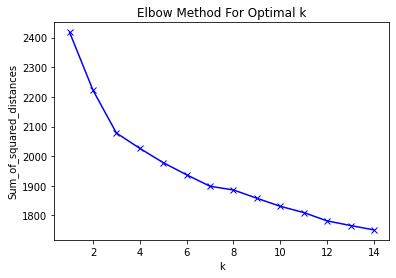

In [31]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km = km.fit(popular_categories_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Silhouette Analysis

Used to select the optimal k value

In [182]:
for i, k in enumerate(np.arange(3,10)):    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k, random_state=0)
    labels = km.fit_predict(popular_categories_clustering)

    # Get silhouette samples
    silhouette_vals = silhouette_samples(popular_categories_clustering, labels)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    print(k, avg_score)

3 0.07485333847737813
4 0.07334572668233211
5 0.07763826969228714
6 0.0803351211870396
7 0.04966248589063176
8 0.04666281286313387
9 0.04660223554929385


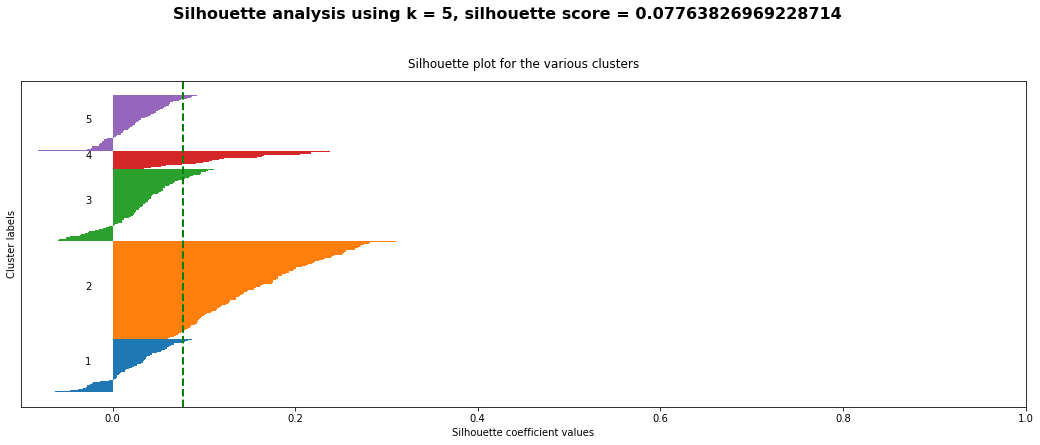

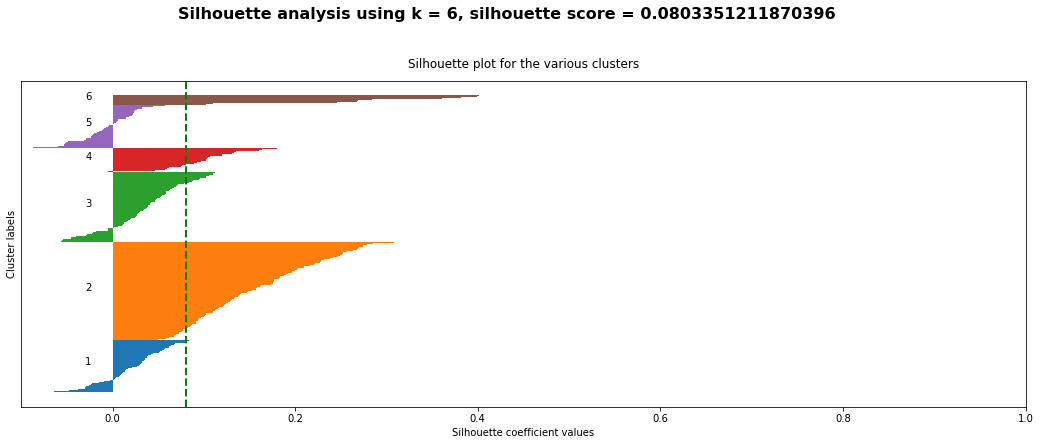

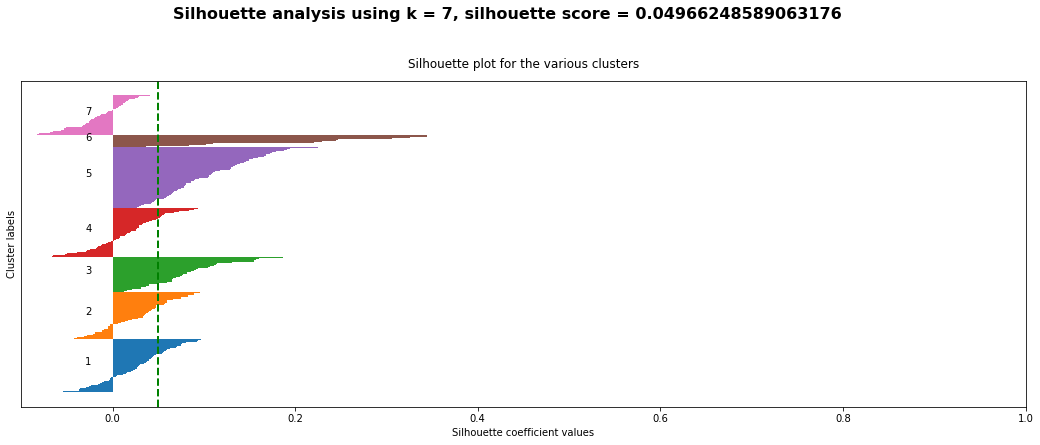

In [196]:
for i, k in enumerate([5, 6, 7]):
    fig, ax1= plt.subplots(1, 1)
    fig.set_size_inches(18, 6)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k, random_state=0)
    labels = km.fit_predict(popular_categories_clustering)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(popular_categories_clustering, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    plt.suptitle(f'Silhouette analysis using k = {k}, silhouette score = {avg_score}', fontsize=16, fontweight='semibold', y=1.05);

We want the Silhouette Score to be as high as possible, hence we select k=6.

### KMeans

In [155]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(popular_categories_clustering)

# check cluster labels generated for each row in the dataframe
print("No of lables generated: {}".format(len(kmeans.labels_)))
kmeans.labels_[0:10] 

No of lables generated: 408


array([2, 1, 1, 1, 1, 1, 2, 3, 0, 0])

In [172]:
# add clustering labels
neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_+1

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nbh_merged = neighborhoods.merge(neighborhoods_venues_sorted, on='Neighborhood')

# to get the city
nbh_df = nbh_merged.copy()
nbh_df['Splitted'] = nbh_df['Neighborhood'].str.split(', ')
nbh_df['City'] = nbh_df.apply(get_city, axis=1)
nbh_df.drop(columns=['Splitted'], inplace=True)
print(nbh_merged.shape)
nbh_df.head() # check the last columns!

(408, 14)


,Neighborhood,Latitude,Longitude,1st Most Popular Venue,2nd Most Popular Venue,3rd Most Popular Venue,4th Most Popular Venue,5th Most Popular Venue,6th Most Popular Venue,7th Most Popular Venue,8th Most Popular Venue,9th Most Popular Venue,10th Most Popular Venue,Cluster Labels,City
0,"Wakefield, Bronx, New York",40.894705,-73.847201,Donut Shop,Pharmacy,Fast Food Restaurant,Fried Chicken Joint,Supermarket,Gas Station,Ice Cream Shop,Discount Store,Bank,Park,3,New York
1,"Co-op City, Bronx, New York",40.874294,-73.829939,Shopping Mall,Supermarket,Donut Shop,Discount Store,Convenience Store,Pizza Place,Grocery Store,BBQ Joint,Department Store,Pharmacy,3,New York
2,"Eastchester, Bronx, New York",40.887556,-73.827806,Supermarket,Shopping Mall,Grocery Store,Fast Food Restaurant,Deli / Bodega,Gym / Fitness Center,Gas Station,Cocktail Bar,Donut Shop,Discount Store,3,New York
3,"Fieldston, Bronx, New York",40.895437,-73.905643,Park,Donut Shop,Fast Food Restaurant,Steakhouse,Playground,Bank,Pizza Place,Bar,Bus Station,Burger Joint,1,New York
4,"Riverdale, Bronx, New York",40.890834,-73.912585,Park,Playground,Bagel Shop,Bank,Coffee Shop,Deli / Bodega,Donut Shop,Bar,Bus Station,Mexican Restaurant,1,New York


# Results

Found the top 10 popular venues for each cluster.


Cluster 1: Pharmacies are more popular  
Cluster 2: Parks are more popular  
Cluster 3: Donut Shops are more popular  
Cluster 4: Grocery Stores are more popular  
Cluster 5: Coffee Shops are more popular  
Cluster 6: Shopping Malls are more popular 

When someone enters the neigborhood they live in New York, it will output the suggested neighborhoods in Toronto, if any, and also display the top 5 popular venue categories in their cluster.

Also noticed that Cluster 1 & 4 have only neighborhoods of New York and Cluster 6 have only neighborhoods of Toronto. So we get to know, neighborhoods in these clusters are dissimilar with the neighborhoods of their respective other city

## Insights on Cluster

In [157]:
# adding cluster labels
popular_categories_clustering['Cluster Labels'] = kmeans.labels_+1

# getting the mean values for each cluster label
cluster_df = popular_categories_clustering.groupby('Cluster Labels').mean()
cluster_df.reset_index(inplace=True)

# get the top 10 popular venues for each of the cluster labels
cluster_top10_venues = get_top10_popular_venues(cluster_df, record_type='Cluster Labels')
print(cluster_top10_venues.shape)
cluster_top10_venues

(6, 11)


,Cluster Labels,1st Most Popular Venue,2nd Most Popular Venue,3rd Most Popular Venue,4th Most Popular Venue,5th Most Popular Venue,6th Most Popular Venue,7th Most Popular Venue,8th Most Popular Venue,9th Most Popular Venue,10th Most Popular Venue
0,1,Pharmacy,Donut Shop,Supermarket,Pizza Place,Bank,Coffee Shop,Bagel Shop,Italian Restaurant,Convenience Store,Deli / Bodega
1,2,Park,Grocery Store,Coffee Shop,Pizza Place,Pharmacy,Restaurant,Bank,Fast Food Restaurant,Italian Restaurant,Bakery
2,3,Pharmacy,Donut Shop,Supermarket,Fast Food Restaurant,Grocery Store,Pizza Place,Discount Store,Park,Fried Chicken Joint,Bank
3,4,Grocery Store,Park,Gym,Hotel,Burger Joint,Coffee Shop,Gym / Fitness Center,Bakery,Pizza Place,Restaurant
4,5,Park,Coffee Shop,Grocery Store,Restaurant,Bar,Café,Gym,Pizza Place,Bakery,Supermarket
5,6,Shopping Mall,Hotel,Park,Supermarket,Plaza,Coffee Shop,Grocery Store,Bookstore,Gym,Gastropub


## Suggested Neighborhoods in the other city

In [174]:
# Wakefield, Bronx, New Yorkv
nbh_name = input('Please enter the Neighborhood Name: ')
city = nbh_name.split(', ')[-1]
other_city = 'Toronto' if city == 'New York' else 'New York'
cluster = nbh_merged.loc[nbh_merged.Neighborhood==nbh_name, 'Cluster Labels'].values[0]
print("\n Cluster: {} ".format(cluster))
top5_venues = cluster_top10_venues.loc[cluster_top10_venues['Cluster Labels']==cluster,cluster_top10_venues.columns[1:6]].values[0]
print("\nThe top 5 popular venues for the cluster are: ")
for venue in top5_venues:
    print(venue)
    
similar_nbhs = nbh_df.loc[(nbh_df.City==other_city)&(nbh_df['Cluster Labels'] == cluster), 'Neighborhood'].values[:5]
if len(similar_nbhs)==0:
    print("\nSorry, No Similar Neighborhoods found in {}".format(other_city))
else:
    print('\nThe other similar neighborhoods you might be interested in {} are: '.format(other_city))
    for nbh in similar_nbhs:
        print(nbh)

Please enter the Neighborhood Name: Wakefield, Bronx, New York

 Cluster: 3 

The top 5 popular venues for the cluster are: 
Pharmacy
Donut Shop
Supermarket
Fast Food Restaurant
Grocery Store

The other similar neighborhoods you might be interested in Toronto are: 
M4H, Thorncliffe Park, East York, Toronto
M2N, Willowdale, Willowdale East, North York, Toronto


In [170]:
# get the count of neighborhoods for each cluster and city pair
nbh_df.groupby(['Cluster Labels', 'City']).count()['Neighborhood'].reset_index().rename(columns={'Neighborhood': 'Neighborhood Count'})

,Cluster Labels,City,Neighborhood Count
0,1,New York,72
1,2,New York,67
2,2,Toronto,67
3,3,New York,94
4,3,Toronto,2
5,4,New York,34
6,5,New York,39
7,5,Toronto,20
8,6,Toronto,13


We notice Cluster 1 & 4 have only neighborhoods of New York and Cluster 6 have only neighborhoods of Toronto. So we get to know, neighborhoods in these clusters are dissimilar with the neighborhoods of their respective other cities

## Visualize the Clusters

In [178]:
ny_location = Nominatim(user_agent="ny_explorer").geocode('New York City, NY')
ny_latitude = location.latitude
ny_longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(ny_latitude, ny_latitude))
to_location = Nominatim(user_agent="to_explorer").geocode('Toronto City, TO')
to_latitude = to_location.latitude
to_longitude = to_location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(to_latitude, to_latitude))

The geograpical coordinate of New York City are 40.7127281, 40.7127281.
The geograpical coordinate of Toronto City are 43.6534817, 43.6534817.


### New York Map

In [179]:
# create map
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11)
nbh_ny_df = nbh_df[nbh_df.City=='New York'].copy()

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nbh_ny_df['Latitude'], nbh_ny_df['Longitude'], nbh_ny_df['Neighborhood'], nbh_ny_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Toronto Map

In [180]:
# create map
to_map_clusters = folium.Map(location=[to_latitude, to_longitude], zoom_start=11)
nbh_to_df = nbh_df[nbh_df.City=='Toronto'].copy()

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nbh_to_df['Latitude'], nbh_to_df['Longitude'], nbh_to_df['Neighborhood'], nbh_to_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(to_map_clusters)
       
to_map_clusters

# Discussion

I would like to discuss the further improvements that could be made to the model. 

1. The data can be analyzed further, for any opportunity available for further data cleaning work.

2. We can try to visualize the data, and get to know about the shape of data, and try to select a most suitable clustering algorithm based on the shape of the data.

# Conclusion

Hence a model has been prepared using the KMeans algorithm on the New York and Toronto Neighborhood Data, with the motive to cluster the neighbourhoods based on the popularity of the venue categories that are provided by the Foursquare. And hence find out similar neighborhoods among both the cities. 